In [269]:
%%HTML
<style>
    body {
        --vscode-font-family: "ComicSansMS"
    }
</style>

## LDO Analysis for C/ID

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [271]:
## Design requirements
kT = 1.38e-23 * 300 # Boltzmann constant times temperature in Kelvin
Gamma = 2/3
PSRR_dB = -60
V_ctrl = 0.9
V_dd = 1.8
V_out = 1.2
f_bw = 1e6
I_load = 1e-3
PM_target = 60 # degrees
Noise_target = 250e-6 # Integrated noise target

In [272]:
## Determining Gain requirements of the Amplifier in feedback

Amp_gain_target = (10**(-1*PSRR_dB/20)) * (V_out / V_ctrl)
Amp_gain_target_dB = 20 * np.log10(Amp_gain_target)
print("Target Gain of the Amplifier in feedback: ", Amp_gain_target)
print("Target Gain of the Amplifier in feedback (dB): ", Amp_gain_target_dB)

Target Gain of the Amplifier in feedback:  1333.3333333333333
Target Gain of the Amplifier in feedback (dB):  62.498774732166


In [273]:
## Bandwidth estimation

C_L = 1.5e-12 # Load capacitance - starting value can change later if noise requirements are not met

## Assuming dominant pole comes from the main circuit
R_eff = 1/(f_bw * 2 * np.pi * C_L)
print("Effective Resistance seen by the load capacitance: ", R_eff)

I_total = (V_out / R_eff) + I_load
print("Total Current flowing through the lPMOS: ", I_total*1e3, "mA")

print("Overhead of the LDO: ", (I_total - I_load)*1e3, "mA")
print("overhead percentage of the LDO: ", ((I_total - I_load) / I_total) * 100, "%")

Effective Resistance seen by the load capacitance:  106103.29539459689
Total Current flowing through the lPMOS:  1.0113097335529233 mA
Overhead of the LDO:  0.011309733552923194 mA
overhead percentage of the LDO:  1.1183253930712158 %


In [274]:
## Amplifier bandwidth estimation
factor = np.tan(PM_target * np.pi / 180) # Converting PM to radians
factor = np.ceil(factor)
print("Bandwidth factor due to PM requirements: ", factor,"x")
Amp_bw = f_bw * factor # Assuming 10 times the bandwidth of the system

print("Target Bandwidth of the Amplifier: ", Amp_bw*1e-6, "MHz")

GBW_Amp = Amp_gain_target * Amp_bw
print("Gain-Bandwidth Product of the Amplifier: ", GBW_Amp*1e-9, "GHz")

Bandwidth factor due to PM requirements:  2.0 x
Target Bandwidth of the Amplifier:  2.0 MHz
Gain-Bandwidth Product of the Amplifier:  2.6666666666666665 GHz


In [275]:
## Noise estimation
Noise_bandwidth = 5*f_bw # Assuming a 2nd order system
PSD_target = Noise_target**2 / (f_bw) # Assuming uniform distribution of noise over the bandwidth
print("Power Spectral Density target: ", PSD_target, "V^2/Hz")

## Assume equal noise contribution from amp and non-amp
V_noise_amp = Noise_target / np.sqrt(2)
V_noise_LDO = Noise_target / np.sqrt(2)

V_noise_amp_input = V_noise_amp / (Amp_gain_target)

print("Target output referred noise contribution from Amp: ", V_noise_amp*1e6, "uV")
print("Target input referred noise contribution from Amp: ", V_noise_amp_input*1e6, "uV")

V_noise_Reff = np.sqrt((4*kT*R_eff)*Noise_bandwidth)
print("R_eff noise contribution: ", V_noise_Reff*1e6, "uV")

V_noise_PMOS_target = np.sqrt((V_noise_LDO**2) - (V_noise_Reff**2))
print("PMOS noise target: ", V_noise_PMOS_target*1e6, "uV")
PSD_PMOS_target = V_noise_PMOS_target**2 / Noise_bandwidth
gm_PMOS_target = PSD_PMOS_target/(4*kT*(R_eff**2))
print("Target gm of the pass transistor: ", gm_PMOS_target*1e3, "mS")

gm_ID_target = gm_PMOS_target / (I_total)
print("kgm target of the pass transistor: ", gm_ID_target)

Power Spectral Density target:  6.25e-14 V^2/Hz
Target output referred noise contribution from Amp:  176.7766952966369 uV
Target input referred noise contribution from Amp:  0.13258252147247768 uV
R_eff noise contribution:  93.73021315815207 uV
PMOS noise target:  149.8821108115554 uV
Target gm of the pass transistor:  0.024099693510322186 mS
kgm target of the pass transistor:  0.023830180518143916


In [276]:
## Amplifier requirements
print("\n\nSummary of the Amplifier requirements:")
print("Gain: ", Amp_gain_target, " (", Amp_gain_target_dB, "dB )")
print("Input referred noise: ", V_noise_amp_input*1e6, "uV")
print("Bandwidth: ", Amp_bw*1e-6, "MHz")




Summary of the Amplifier requirements:
Gain:  1333.3333333333333  ( 62.498774732166 dB )
Input referred noise:  0.13258252147247768 uV
Bandwidth:  2.0 MHz


In [277]:
## gm requirements estimation based on bandwidth for a single stage amp

Cgs_pmos = 100e-12
C_par_amp = 50e-12

C_Load_1 = Cgs_pmos + C_par_amp

gm_target_bw =  (2 * np.pi * Amp_bw * C_Load_1)
print("Minimum gm requirement of the amplifier for the given bandwidth: ", gm_target_bw*1e3, "mS")

Minimum gm requirement of the amplifier for the given bandwidth:  1.8849555921538759 mS


In [278]:
## gm requirements estimation based on noise requirements for a single stage amp

Noise_bandwidth_amp = 5*Amp_bw

PSD_target_amp = (V_noise_amp**2) / Noise_bandwidth_amp

gm_target_noise = 4*kT*Gamma / PSD_target_amp

print("Minimum gm requirement of the amplifier for the given noise target: ", gm_target_noise*1e3, "mS")

Minimum gm requirement of the amplifier for the given noise target:  0.003532800000000001 mS


In [279]:
## gm requirements for design
gm_target = max(gm_target_bw, gm_target_noise)
print("Minimum gm requirement of the amplifier for the given design: ", gm_target*1e3, "mS")

Minimum gm requirement of the amplifier for the given design:  1.8849555921538759 mS


## Updated estimate om Sep 06 2025

In [280]:
C_load_eff = 100.4e-12 # Effective load capacitance including parasitics from previous analysis

R_L_eff = 290 # Effective load resistance including pass transistor rds from previous analysis

## Bandwidth target and Reff estimate
BW_target = 1e6  # 2MHz

f_bw = 1/(2 * np.pi * R_L_eff * C_load_eff)
print(f"Achieved Bandwidth with R_L_eff {R_L_eff:.2f} Ohms and C_load_eff {C_load_eff*1e12:.1f} pF: {f_bw*1e-6:.2f} MHz")

C_scale = f_bw / BW_target
print(f"Capacitance scaling factor to achieve target BW {BW_target*1e-6:.1f} MHz: {C_scale:.3f}x")


Achieved Bandwidth with R_L_eff 290.00 Ohms and C_load_eff 100.4 pF: 5.47 MHz
Capacitance scaling factor to achieve target BW 1.0 MHz: 5.466x


# Reestimating pole requriements for the design on Sep 06 2025

In [281]:
f_bw = 1e6
Ao = 1000 # 60dB
PM_target = 60 # degrees

f_u = f_bw * Ao
print(f"Unity Gain Frequency (f_u) of the Amplifier for BW target {f_bw*1e-6:.1f} MHz and Gain {Ao} (60dB): {f_u*1e-6:.2f} MHz")

f_p2 = f_u*np.tan(np.radians(PM_target))
print(f"Required location of the 2nd pole (f_p2) for PM target {PM_target} degrees: {f_p2*1e-6:.2f} MHz")

f_p3 = f_p2 * 2
print(f"Required location of the 3rd pole (f_p3) for stability: {f_p3*1e-6:.2f} MHz")


Unity Gain Frequency (f_u) of the Amplifier for BW target 1.0 MHz and Gain 1000 (60dB): 1000.00 MHz
Required location of the 2nd pole (f_p2) for PM target 60 degrees: 1732.05 MHz
Required location of the 3rd pole (f_p3) for stability: 3464.10 MHz


In [282]:
## Estimating circuit paramters for f_p3 for a source follower stage
C_load = 11.4e-12
R_eff = 1/(2 * np.pi * f_p3 * C_load)
print(f"Effective Resistance (R_eff) seen by the load capacitance {C_load*1e12:.1f} pF for f_p3 {f_p3*1e-6:.2f} MHz: {R_eff:.2f} Ohms")

Effective Resistance (R_eff) seen by the load capacitance 11.4 pF for f_p3 3464.10 MHz: 4.03 Ohms


## LDO High level Optimization strategy
1. Bandwidth
2. Power budget
3. PSRR
4. Slewing 

In [283]:
## Amplifer design parameters based on pass transistor design targets
C_load = 11.4e-12 # Comes from the pass transistor design
f_bw = 1e6
k = 3/4 # 0.9V ctrl voltage and 1.2V LDO output voltage
I_load = 10e-3 # LDO load current through the pass transistor
Av_pass = 25 # Gain of the pass transistor stage

In [284]:
## 1st case, 10% of I_load and 60 dB PSRR
PSRR_target_dB = -60
PSRR_target = 10**(PSRR_target_dB/20)
I_budget = (10/100) * I_load
Av_amp = (10**(-PSRR_target_dB/20)) * (1/(k*Av_pass))
print(f"Amplifier Gain (Av_amp) requirement for {I_budget*1e3:.1f} mA budget and 60 dB PSRR: {Av_amp:.2f} V/V")

Amplifier Gain (Av_amp) requirement for 1.0 mA budget and 60 dB PSRR: 53.33 V/V


In [285]:
## Pole requirements for stability
f_u = (1/PSRR_target)*f_bw
f_p2 = f_u * np.tan(np.radians(PM_target))
f_p3 = f_p2 * 2

print(f"Unity Gain Frequency (f_u) of the Amplifier for BW target {f_bw*1e-6:.1f} MHz and PSRR target {PSRR_target_dB} dB: {f_u*1e-6:.2f} MHz")
print(f"Required location of the 2nd pole (f_p2) for PM target {PM_target} degrees: {f_p2*1e-6:.2f} MHz")
print(f"Required location of the 3rd pole (f_p3) for stability: {f_p3*1e-6:.2f} MHz")

Unity Gain Frequency (f_u) of the Amplifier for BW target 1.0 MHz and PSRR target -60 dB: 1000.00 MHz
Required location of the 2nd pole (f_p2) for PM target 60 degrees: 1732.05 MHz
Required location of the 3rd pole (f_p3) for stability: 3464.10 MHz


In [286]:
## Assuming first stage dominant pole and second stage of amp is a source follower
Av_2 = 1 # Gain of the 2nd stage of the amplifier
Av_1 = Av_amp / Av_2

In [287]:
GBW_stage1 = Av_1 * f_p2
GBW_stage2 = Av_2 * f_p3

print(f"Gain-Bandwidth Product of stage 1 (GBW_stage1) with Av_1 {Av_1:.2f} and f_p2 {f_p2*1e-6:.2f} MHz: {GBW_stage1*1e-9:.2f} GHz")
print(f"Gain-Bandwidth Product of stage 2 (GBW_stage2) with Av_2 {Av_2:.2f} and f_p3 {f_p3*1e-6:.2f} MHz: {GBW_stage2*1e-9:.2f} GHz")

Gain-Bandwidth Product of stage 1 (GBW_stage1) with Av_1 53.33 and f_p2 1732.05 MHz: 92.38 GHz
Gain-Bandwidth Product of stage 2 (GBW_stage2) with Av_2 1.00 and f_p3 3464.10 MHz: 3.46 GHz


In [288]:
## Checking second stage GBW feasibility
kgm_max = 25 # Arbitrary max value for 180nm technology
gm_req = 2 * np.pi * C_load * GBW_stage2 
I_req = gm_req / kgm_max
print(f"Required gm of the 2nd stage of the amplifier for GBW_stage2 {GBW_stage2*1e-9:.2f} GHz and C_load {C_load*1e12:.1f} pF: {gm_req*1e3:.2f} mS")
print(f"Required current of the 2nd stage of the amplifier for kgm_max {kgm_max} : {I_req*1e3:.2f} mA")

Required gm of the 2nd stage of the amplifier for GBW_stage2 3.46 GHz and C_load 11.4 pF: 248.13 mS
Required current of the 2nd stage of the amplifier for kgm_max 25 : 9.93 mA


In [289]:
## Converting this into a function for varying PSRR and I_budget just for the second stage
def analyze_second_stage(PSRR_target_dB, I_budget):
    PSRR_target = 10**(PSRR_target_dB/20)
    f_u = (1/PSRR_target)*f_bw
    f_p2 = f_u * np.tan(np.radians(PM_target))
    f_p3 = f_p2 * 2

    GBW_stage2 = Av_2 * f_p3

    kgm_max = 25 # Arbitrary max value for 180nm technology
    gm_req = 2 * np.pi * C_load * GBW_stage2
    I_req = gm_req / kgm_max
    # print(f"Required gm of the 2nd stage of the amplifier for GBW_stage2 {GBW_stage2*1e-9:.2f} GHz and C_load {C_load*1e12:.1f} pF: {gm_req*1e3:.2f} mS")
    # print(f"Required current of the 2nd stage of the amplifier for kgm_max {kgm_max} : {I_req*1e3:.2f} mA while having I_budget {I_budget*1e3:.1f} mA and PSRR_target {PSRR_target_dB} dB")
    return I_req

I_req_2 = analyze_second_stage(-35, (5/100)*I_load)

Closest I_req_2 to I_budget: 0.4974 mA at PSRR = -34 dB


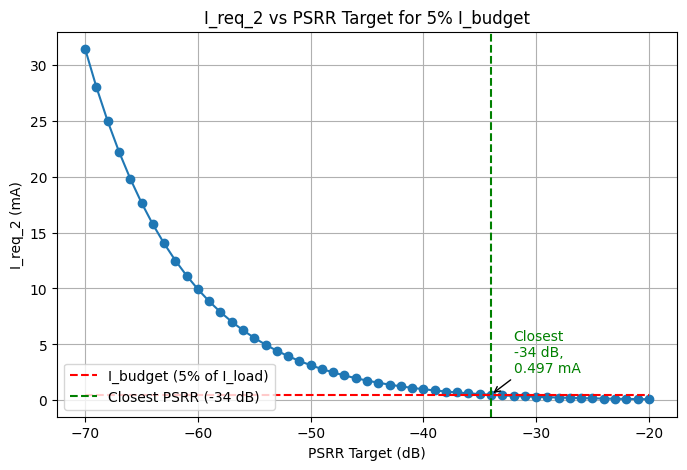

In [290]:
import matplotlib.pyplot as plt

PSRR_targets_dB = np.arange(-70, -19, 1)
I_budget = 0.05 * I_load
I_req_2_list = []

for psrr_db in PSRR_targets_dB:
    I_req_2_list.append(analyze_second_stage(psrr_db, I_budget))


I_req_2_arr = np.array(I_req_2_list)
idx_closest = np.argmin(np.abs(I_req_2_arr - I_budget))
i_req_closest = I_req_2_arr[idx_closest]
psrr_closest = PSRR_targets_dB[idx_closest]
print(f"Closest I_req_2 to I_budget: {i_req_closest*1e3:.4f} mA at PSRR = {psrr_closest} dB")



plt.figure(figsize=(8,5))
plt.plot(PSRR_targets_dB, np.array(I_req_2_list)*1e3, marker='o')
plt.hlines(I_budget*1e3, PSRR_targets_dB[0], PSRR_targets_dB[-1], color='r', linestyle='--', label='I_budget (5% of I_load)')
plt.axvline(psrr_closest, color='g', linestyle='--', label=f'Closest PSRR ({psrr_closest} dB)')
plt.annotate(f'Closest\n{psrr_closest} dB,\n{(i_req_closest*1e3):.3f} mA',
             xy=(psrr_closest, i_req_closest*1e3),
             xytext=(psrr_closest+2, i_req_closest*1e3+2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='g')
plt.legend()
plt.xlabel('PSRR Target (dB)')
plt.ylabel('I_req_2 (mA)')
plt.title('I_req_2 vs PSRR Target for 5% I_budget')
plt.grid(True)
plt.show()

## Next steps 
1. Extract Kgm vs kcg data for a source follower by sweeping the current.
2. Large signal needs to be captured since V_g of PMOS needs to be close to 1.25V
3. Vin will be set as 1.3V  

In [291]:
# Extract parameters
param_master = pd.read_csv("sf_nmos_char_vg_1_3.csv")

In [292]:
kgm_n = np.abs(param_master['kgmn Y'])
kcsg_n = np.abs(param_master['kcgs_n Y'])
kcgd_n = np.abs(param_master['kcgd_n Y'])
kgds_n = np.abs(param_master['kgds_n Y'])
ids = np.abs(param_master['ids Y'])
I_sweep = np.abs(param_master['ids X']) 

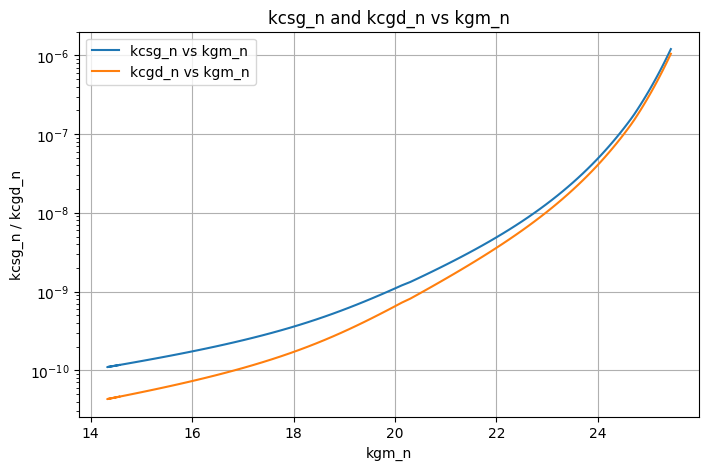

In [293]:
plt.figure(figsize=(8,5))
plt.plot(kgm_n, kcsg_n, label='kcsg_n vs kgm_n')
plt.plot(kgm_n, kcgd_n, label='kcgd_n vs kgm_n')
plt.yscale('log')
plt.xlabel('kgm_n')
plt.ylabel('kcsg_n / kcgd_n')
plt.title('kcsg_n and kcgd_n vs kgm_n')
plt.legend()
plt.grid(True)
plt.show()

In [294]:
I_target = i_req_closest
print(f"Target current for the 2nd stage from kgm = 25 assumption: {I_target*1e3:.3f} mA")

# Find the index where kgm_n is closest to kgm_max (target kgm)
idx_kgm = (kgm_n - kgm_max).abs().idxmin()
ksg_at_kgm = kcsg_n.iloc[idx_kgm]
kcgd_at_kgm = kcgd_n.iloc[idx_kgm]
print(f"At kgm ≈ {kgm_max}: kcsg_n = {ksg_at_kgm:.3e}, kcgd_n = {kcgd_at_kgm:.3e}")
cgs_nmos = ksg_at_kgm * I_target
cgd_nmos = kcgd_at_kgm * I_target
Cg_in = cgs_nmos + cgd_nmos * (1 + Av_2)
print(f"At I_target = {I_target*1e3:.3f} mA, cgs_nmos = {cgs_nmos*1e15:.2f} fF, cgd_nmos = {cgd_nmos*1e15:.2f} fF")
print(f"At I_target = {I_target*1e3:.3f} mA, Cg_in = {Cg_in*1e12:.2f} pF")


Target current for the 2nd stage from kgm = 25 assumption: 0.497 mA
At kgm ≈ 25: kcsg_n = 3.514e-07, kcgd_n = 3.017e-07
At I_target = 0.497 mA, cgs_nmos = 174820.08 fF, cgd_nmos = 150098.75 fF
At I_target = 0.497 mA, Cg_in = 475.02 pF


### Estimating the I_required of the first stage with this design constraints

In [295]:
gm_req_stg_1 = GBW_stage1*2 * np.pi * Cg_in
print(f"Required gm of the 1st stage of the amplifier for GBW_stage1 {GBW_stage1*1e-6:.2f} MHz and Cg_in {Cg_in*1e12:.2f} pF: {gm_req_stg_1*1e3:.2f} mS")

kgm_max = 25 # Arbitrary max value for 180nm technology
I_req_stg_1 = gm_req_stg_1 / kgm_max

print(f"Required current of the 1st stage of the amplifier for kgm_max {kgm_max} : {I_req_stg_1*1e3:.2f} mA, while having I_budget {I_budget*1e3:.1f} mA and PSRR_target {psrr_closest} dB")


Required gm of the 1st stage of the amplifier for GBW_stage1 92376.04 MHz and Cg_in 475.02 pF: 275707.70 mS
Required current of the 1st stage of the amplifier for kgm_max 25 : 11028.31 mA, while having I_budget 0.5 mA and PSRR_target -34 dB


### Wrapping the first pass estimations in to a function to estimate small signal feasibility 

## Planning the function out
Input: PSRR_dB, I_budget
Output: I_req_stg_1, I_req_stg_2, I_req_total

1. Estimate I_req2 based on analysis
2. Estimate Cin for the second stage
3. Estimate I_req1 based on analysis

In [296]:
def estimate_C_in_stg2(csv_file, I_req, kgm_target):
    """
    Estimate the input capacitance (C_in) for a source follower stage
    by finding the closest kgm in the data and using the corresponding kcgs and kcgd.

    Args:
        csv_file (str): Path to the CSV file with device parameters.
        I_req (float): Required current (A).
        kgm_target (float): Target kgm value.

    Returns:
        float: Estimated input capacitance (F).
        dict: Dictionary with details at the selected point.
    """
    df = pd.read_csv(csv_file)
    kgm_n = np.abs(df['kgmn Y'])
    kcsg_n = np.abs(df['kcgs_n Y'])
    kcgd_n = np.abs(df['kcgd_n Y'])

    idx_kgm = (kgm_n - kgm_target).abs().idxmin()
    ksg_at_kgm = kcsg_n.iloc[idx_kgm]
    kcgd_at_kgm = kcgd_n.iloc[idx_kgm]

    cgs = ksg_at_kgm * I_req
    cgd = kcgd_at_kgm * I_req
    # For a source follower, Av_2 = 1 (as in your notebook)
    C_in = cgs + cgd * (1 + 1)

    details = {
        'idx_kgm': idx_kgm,
        'kgm': kgm_n.iloc[idx_kgm],
        'kcsg_n': ksg_at_kgm,
        'kcgd_n': kcgd_at_kgm,
        'cgs': cgs,
        'cgd': cgd,
        'C_in': C_in
    }
    return C_in, details

In [297]:
# Test the estimate_C_in_stg2 function using the available data and variables
csv_file = "sf_nmos_char_vg_1_3.csv"
I_req_test = I_target  # Use the previously calculated I_target
kgm_target_test = 25

C_in_test, details_test = estimate_C_in_stg2(csv_file, I_req_test, kgm_target_test)
print(f"Estimated C_in: {C_in_test*1e12:.2f} pF")
print("Details at selected point:", details_test)

Estimated C_in: 475.02 pF
Details at selected point: {'idx_kgm': 9, 'kgm': np.float64(25.00386507127838), 'kcsg_n': np.float64(3.514438674718297e-07), 'kcgd_n': np.float64(3.017461437348191e-07), 'cgs': np.float64(1.7482007552946473e-10), 'cgd': np.float64(1.500987455491e-10), 'C_in': np.float64(4.750175666276647e-10)}


In [298]:
def extract_I_req_stage1(C_out, GBW_stage1, kgm_max=25):
    """
    Estimate the required current for the first stage of the amplifier
    given the output capacitance, GBW, and maximum kgm.

    Args:
        C_in (float): Input capacitance of the first stage (F).
        GBW_stage1 (float): Gain-bandwidth product for the first stage (Hz).
        kgm_max (float): Maximum allowed gm/I (default: 25 S/A).

    Returns:
        float: Required current for the first stage (A).
    """
    gm_req = 2 * np.pi * C_out * GBW_stage1
    I_req = gm_req / kgm_max
    return I_req

In [299]:
# Test extract_I_req_stage1 function using available variables
C_out_test = Cg_in  # Use Cg_in as the output capacitance for stage 1
GBW_stage1_test = GBW_stage1  # Use previously calculated GBW_stage1

I_req_stage1_test = extract_I_req_stage1(C_out_test, GBW_stage1_test, kgm_max)
print(f"Estimated I_req_stage1: {I_req_stage1_test*1e3:.3f} mA")

Estimated I_req_stage1: 11028.308 mA


In [300]:
def estimate_amplifier_stages(csv_file, PSRR_target_dB, I_budget, kgm_target=25):
    """
    Estimate the required currents for both amplifier stages and total current.

    Args:
        csv_file (str): Path to the CSV file with device parameters.
        PSRR_target_dB (float or int): PSRR target in dB.
        I_budget (float): Current budget for the second stage (A).
        kgm_target (float): Target kgm value for both stages (default: 25).

    Returns:
        dict: {
            'I_req_stage2': Required current for stage 2 (A),
            'C_in_stage2': Estimated input capacitance for stage 2 (F),
            'I_req_stage1': Required current for stage 1 (A),
            'I_req_total': Total required current (A),
            'details_stage2': Details at selected point for stage 2
        }
    """
    # 1. Estimate I_req2 based on PSRR and I_budget
    I_req_stage2 = analyze_second_stage(PSRR_target_dB, I_budget)
    # 2. Estimate Cin for the second stage
    C_in_stage2, details_stage2 = estimate_C_in_stg2(csv_file, I_req_stage2, kgm_target)
    # 3. Estimate I_req1 based on Cin and GBW_stage1
    I_req_stage1 = extract_I_req_stage1(C_in_stage2, GBW_stage1, kgm_target)
    # 4. Total required current
    I_req_total = I_req_stage1 + I_req_stage2

    print(f"Stage 2 required current (I_req_stage2): {I_req_stage2*1e3:.4f} mA")
    print(f"Stage 2 input capacitance (C_in_stage2): {C_in_stage2*1e12:.2f} pF")
    print(f"Stage 1 required current (I_req_stage1): {I_req_stage1*1e3:.4f} mA")
    print(f"Total required current (I_req_total): {I_req_total*1e3:.4f} mA")
    return {
        'I_req_stage2': I_req_stage2,
        'C_in_stage2': C_in_stage2,
        'I_req_stage1': I_req_stage1,
        'I_req_total': I_req_total,
        'details_stage2': details_stage2
    }

In [301]:
# Test the estimate_amplifier_stages function using available variables
csv_file = "sf_nmos_char_vg_1_3.csv"
PSRR_target_dB = -40
I_budget = (5/100) * I_load  # 5% of I_load
kgm_max = 25

result = estimate_amplifier_stages(csv_file, PSRR_target_dB, I_budget, kgm_max)
print("Amplifier stages estimation result:")
for k, v in result.items():
    if isinstance(v, float) or isinstance(v, np.floating):
        print(f"{k}: {v:.4e}")
    else:
        print(f"{k}: {v}")

Stage 2 required current (I_req_stage2): 0.9925 mA
Stage 2 input capacitance (C_in_stage2): 947.78 pF
Stage 1 required current (I_req_stage1): 22004.3673 mA
Total required current (I_req_total): 22005.3598 mA
Amplifier stages estimation result:
I_req_stage2: 9.9251e-04
C_in_stage2: 9.4778e-10
I_req_stage1: 2.2004e+01
I_req_total: 2.2005e+01
details_stage2: {'idx_kgm': 9, 'kgm': np.float64(25.00386507127838), 'kcsg_n': np.float64(3.514438674718297e-07), 'kcgd_n': np.float64(3.017461437348191e-07), 'cgs': np.float64(3.4881190860395424e-10), 'cgd': np.float64(2.994863705182221e-10), 'C_in': np.float64(9.477846496403986e-10)}


## Estimating the PSRR spec that brings total current below I_budget

Stage 2 required current (I_req_stage2): 0.9925 mA
Stage 2 input capacitance (C_in_stage2): 947.78 pF
Stage 1 required current (I_req_stage1): 22004.3673 mA
Total required current (I_req_total): 22005.3598 mA
Stage 2 required current (I_req_stage2): 0.8846 mA
Stage 2 input capacitance (C_in_stage2): 844.71 pF
Stage 1 required current (I_req_stage1): 19611.4130 mA
Total required current (I_req_total): 19612.2976 mA
Stage 2 required current (I_req_stage2): 0.7884 mA
Stage 2 input capacitance (C_in_stage2): 752.85 pF
Stage 1 required current (I_req_stage1): 17478.6902 mA
Total required current (I_req_total): 17479.4786 mA
Stage 2 required current (I_req_stage2): 0.7026 mA
Stage 2 input capacitance (C_in_stage2): 670.98 pF
Stage 1 required current (I_req_stage1): 15577.8991 mA
Total required current (I_req_total): 15578.6017 mA
Stage 2 required current (I_req_stage2): 0.6262 mA
Stage 2 input capacitance (C_in_stage2): 598.01 pF
Stage 1 required current (I_req_stage1): 13883.8172 mA
Total r

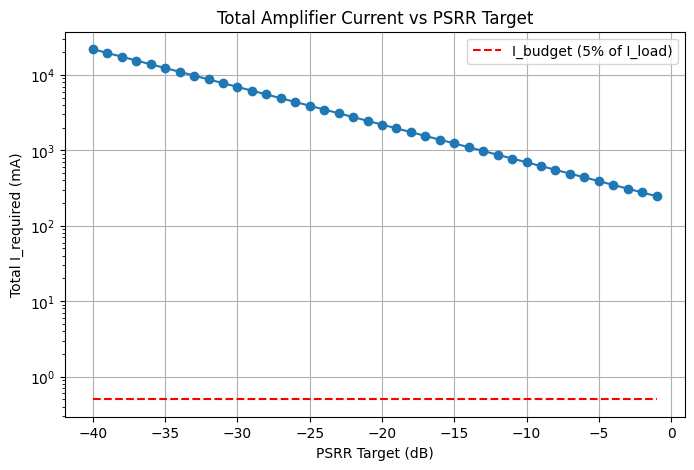

Stage 2 required current (I_req_stage2): 0.9925 mA
Stage 2 input capacitance (C_in_stage2): 947.78 pF
Stage 1 required current (I_req_stage1): 22004.3673 mA
Total required current (I_req_total): 22005.3598 mA
Stage 2 required current (I_req_stage2): 0.8846 mA
Stage 2 input capacitance (C_in_stage2): 844.71 pF
Stage 1 required current (I_req_stage1): 19611.4130 mA
Total required current (I_req_total): 19612.2976 mA
Stage 2 required current (I_req_stage2): 0.7884 mA
Stage 2 input capacitance (C_in_stage2): 752.85 pF
Stage 1 required current (I_req_stage1): 17478.6902 mA
Total required current (I_req_total): 17479.4786 mA
Stage 2 required current (I_req_stage2): 0.7026 mA
Stage 2 input capacitance (C_in_stage2): 670.98 pF
Stage 1 required current (I_req_stage1): 15577.8991 mA
Total required current (I_req_total): 15578.6017 mA
Stage 2 required current (I_req_stage2): 0.6262 mA
Stage 2 input capacitance (C_in_stage2): 598.01 pF
Stage 1 required current (I_req_stage1): 13883.8172 mA
Total r

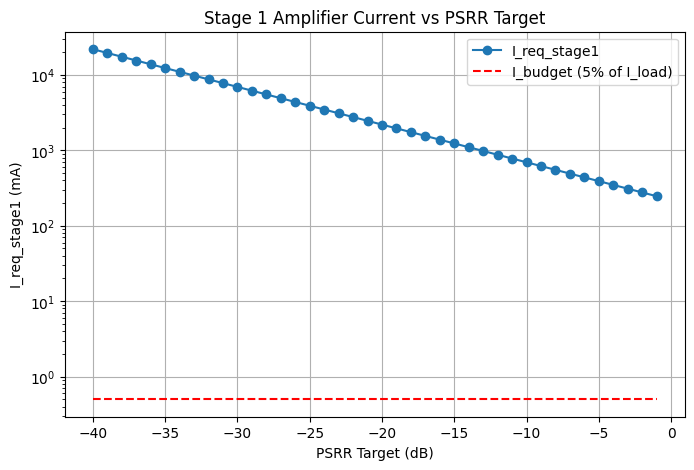

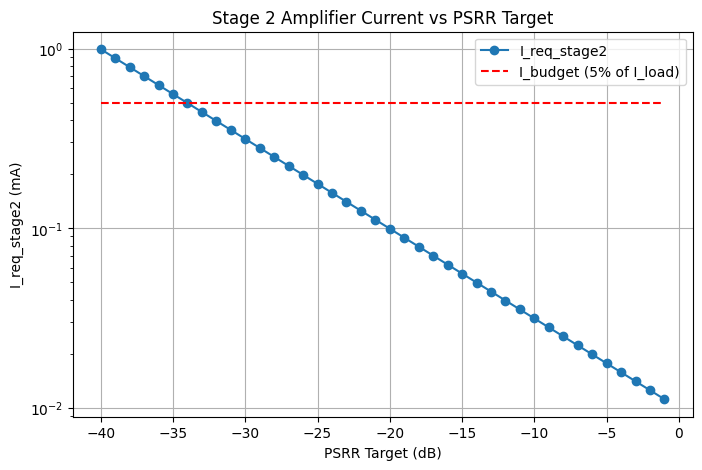

In [302]:
I_budget = (5/100) * I_load  # 5% of I_load

PSRR_sweep = np.arange(-40, 0, 1)
I_total_list = []
for psrr_db in PSRR_sweep:
    res = estimate_amplifier_stages(csv_file, psrr_db, I_budget, kgm_max)
    I_total_list.append(res['I_req_total'])

plt.figure(figsize=(8,5))
plt.plot(PSRR_sweep, np.array(I_total_list)*1e3, marker='o')
plt.hlines(I_budget*1e3, PSRR_sweep[0], PSRR_sweep[-1], color='r', linestyle='--', label='I_budget (5% of I_load)')
plt.yscale('log')
plt.xlabel('PSRR Target (dB)')
plt.ylabel('Total I_required (mA)')
plt.title('Total Amplifier Current vs PSRR Target')
plt.legend()
plt.grid(True)
plt.show()

I_req_stage1_list = []
I_req_stage2_list = []

for psrr_db in PSRR_sweep:
    res = estimate_amplifier_stages(csv_file, psrr_db, I_budget, kgm_max)
    I_req_stage1_list.append(res['I_req_stage1'])
    I_req_stage2_list.append(res['I_req_stage2'])

plt.figure(figsize=(8,5))
plt.plot(PSRR_sweep, np.array(I_req_stage1_list)*1e3, marker='o', label='I_req_stage1')
plt.hlines(I_budget*1e3, PSRR_sweep[0], PSRR_sweep[-1], color='r', linestyle='--', label='I_budget (5% of I_load)')
plt.yscale('log')
plt.xlabel('PSRR Target (dB)')
plt.ylabel('I_req_stage1 (mA)')
plt.title('Stage 1 Amplifier Current vs PSRR Target')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(PSRR_sweep, np.array(I_req_stage2_list)*1e3, marker='o', label='I_req_stage2')
plt.hlines(I_budget*1e3, PSRR_sweep[0], PSRR_sweep[-1], color='r', linestyle='--', label='I_budget (5% of I_load)')
plt.yscale('log')
plt.xlabel('PSRR Target (dB)')
plt.ylabel('I_req_stage2 (mA)')
plt.title('Stage 2 Amplifier Current vs PSRR Target')
plt.legend()
plt.grid(True)
plt.show()

### Next step --> streamline the python script

1. Define PSRR_target,f_bw, PM_target, C_load
2. Estimate GBW1_target, GBW2_target 
3. Pass this to the feasibility script

In [303]:
def estimate_GBW_stages(PSRR_target_dB, f_bw, PM_target, C_load, Av_2=1, k_res_div=3/4, Av_pass=25):
    """
    Estimate the required GBW for stage 1 and stage 2 of the amplifier.

    Args:
        PSRR_target_dB (float or int): PSRR target in dB (negative value).
        f_bw (float): Desired closed-loop bandwidth (Hz).
        PM_target (float or int): Phase margin target (degrees).
        C_load (float): Load capacitance for stage 2 (F).
        Av_2 (float): Gain of stage 2 (default: 1).
        k_res_div (float): Resistive divider ratio (default: 3/4).

    Returns:
        tuple: (GBW_stage1, GBW_stage2) in Hz
    """
    # Convert PSRR from dB to linear
    PSRR_target = 10**(PSRR_target_dB / 20)
    # Unity-gain frequency for the amplifier
    f_u = (1 / PSRR_target) * f_bw
    # Second pole location for phase margin
    f_p2 = f_u * np.tan(np.radians(PM_target))
    # Third pole location for stability
    f_p3 = f_p2 * 2

    # Stage 2 gain (Av_2) is determined by system requirements; here, assume unity due to architecture choice
    Av_2 = 1  # If you want to use a specific Av_1, pass as argument

    Av_1 = (1 / PSRR_target) * (1 / Av_2) * (1/k_res_div) * (1/Av_pass)

    GBW_stage1 = Av_1 * f_p2
    GBW_stage2 = Av_2 * f_p3


    return GBW_stage1, GBW_stage2

In [304]:
# Test the estimate_GBW_stages function using available variables

PSRR_target_dB = -40
f_bw = 1e6
PM_target = 60
C_load = 11.4e-12

GBW_stage1, GBW_stage2 = estimate_GBW_stages(PSRR_target_dB, f_bw, PM_target, C_load)

print(f"Estimated GBW_stage1: {GBW_stage1*1e-9:.2f} GHz")
print(f"Estimated GBW_stage2: {GBW_stage2*1e-9:.2f} GHz")

Estimated GBW_stage1: 0.92 GHz
Estimated GBW_stage2: 0.35 GHz


In [305]:
## Calling the function from LDO_functions.py
from LDO_functions import estimate_amplifier_stages, estimate_GBW_stages
# Test the functions using available variables
csv_file = "sf_nmos_char_vg_1_3.csv"
PSRR_target_dB = -40
f_bw = 1e6
PM_target = 60
C_load = 11.4e-12
kgm_max = 25


In [306]:
GBW_stage1, GBW_stage2 = estimate_GBW_stages(PSRR_target_dB, f_bw, PM_target, C_load)

print(f"Estimated GBW_stage1: {GBW_stage1*1e-9:.2f} GHz")
print(f"Estimated GBW_stage2: {GBW_stage2*1e-9:.2f} GHz")

Estimated GBW_stage1: 0.92 GHz
Estimated GBW_stage2: 0.35 GHz


In [307]:
# Estimate amplifier stages using the current test parameters
result_test = estimate_amplifier_stages(csv_file, PSRR_target_dB, I_budget, kgm_max)
print("Amplifier stages estimation (test):")
for k, v in result_test.items():
    if isinstance(v, float) or isinstance(v, np.floating):
        print(f"{k}: {v:.4e}")
    else:
        print(f"{k}: {v}")

Stage 2 required current (I_req_stage2): 3.1416 mA
Stage 2 input capacitance (C_in_stage2): 3000.02 pF
Stage 1 required current (I_req_stage1): -0.0000 mA
Total required current (I_req_total): 3.1416 mA
Amplifier stages estimation (test):
I_req_stage2: 3.1416e-03
C_in_stage2: 3.0000e-09
I_req_stage1: -3.0159e-08
I_req_total: 3.1416e-03
details_stage2: {'idx_kgm': 9, 'kgm': np.float64(25.00386507127838), 'kcsg_n': np.float64(3.514438674718297e-07), 'kcgd_n': np.float64(3.017461437348191e-07), 'cgs': np.float64(1.1040934721986852e-09), 'cgd': np.float64(9.479634684063574e-10), 'C_in': np.float64(3.0000204090114e-09)}


## Next Steps
1. Writing a function to estimate k_res_div, R_L and Av_pass
2. Writing a function to estimate C_in of pass transistor

In [308]:
Av_pass = 25
I_load = 10e-3
I_res_div = (1/100) * I_load
I_pmos = I_load + I_res_div
print(f"Total current through the PMOS pass transistor (I_pmos): {I_pmos*1e3:.2f} mA")
pmos_pass_char_csv = 'ldo_pmos_kgm_char_Msweep_10mA.csv'

param_master = pd.read_csv(pmos_pass_char_csv)

kgm_p = np.abs(param_master['kgmp Y'])
kcsg_p = np.abs(param_master['kcgs Y'])
kcgd_p = np.abs(param_master['kcgd Y'])
kgds_p = np.abs(param_master['kgds Y'])
ids = np.abs(param_master['ids Y'])
M_scale = np.abs(param_master['kgmp X']) 
vd = np.abs(param_master['vd Y'])

# Find index where both ids is closest to 10mA and vd is closest to 1.2V
idx_both = ((ids - 0.01).abs() + (vd - 1.2).abs()).idxmin()
M_scale_both = M_scale.loc[idx_both]

print(f"M_scale where ids is closest to 10mA and Vd is closest to 1.2V: {M_scale_both:.4f}")


## Estimating gm and gds at M_scale_both
kgm_interp = interp1d(M_scale, kgm_p, kind='linear', fill_value='extrapolate')
gm_p_both = float(kgm_interp(M_scale_both)) * I_pmos  # in Siemens
print(f"gm_p at M_scale {M_scale_both:.4f}: {gm_p_both*1e3:.3f} mS")
kgds_interp = interp1d(M_scale, kgds_p, kind='linear', fill_value='extrapolate')
gds_p_both = float(kgds_interp(M_scale_both)) * I_pmos  # in Siemens
print(f"gds_p at M_scale {M_scale_both:.4f}: {gds_p_both*1e3:.3f} mS")  # in Siemens

Av_pass_both = gm_p_both / gds_p_both
print(f"Av_pass at M_scale {M_scale_both:.4f}: {Av_pass_both:.2f} V/V")

## Estimating the caps at M_scale_both
kcgd_interp = interp1d(M_scale, kcgd_p, kind='linear', fill_value='extrapolate')
cgd_p_both = float(kcgd_interp(M_scale_both)) * 0.01  # in Farads
print(f"kcgd_p at M_scale {M_scale_both:.4f}: {cgd_p_both*1e15:.3f} fF")
kcgs_interp = interp1d(M_scale, kcsg_p, kind='linear', fill_value='extrapolate')
cgs_p_both = float(kcgs_interp(M_scale_both)) * 0.01  # in Farads
print(f"kcgs_p at M_scale {M_scale_both:.4f}: {cgs_p_both*1e15:.3f} fF")

C_in_pass = cgs_p_both + cgd_p_both * (1 + Av_pass_both)
print(f"Effective Input Capacitance at I_min including Miller effect: {C_in_pass*1e12:.3f} pF")


Total current through the PMOS pass transistor (I_pmos): 10.10 mA
M_scale where ids is closest to 10mA and Vd is closest to 1.2V: 888.6238
gm_p at M_scale 888.6238: 85.457 mS
gds_p at M_scale 888.6238: 3.400 mS
Av_pass at M_scale 888.6238: 25.14 V/V
kcgd_p at M_scale 888.6238: 386.141 fF
kcgs_p at M_scale 888.6238: 948.920 fF
Effective Input Capacitance at I_min including Miller effect: 11.041 pF


In [320]:
def estimate_pass_pmos_parameters(csv_file, I_load, I_res_div, Vout_LDO, Vctrl, f_bw, C_out):
    """
    Estimate the effective input capacitance (including Miller effect) of the PMOS pass transistor.

    Args:
        csv_file (str): Path to the CSV file with device parameters.
        I_load (float): Load current (A).
        I_res_div (float): Current through the resistor divider (A).
        Vout_LDO (float): Output voltage of the LDO (V).
        Vctrl (float): Control voltage for error amplifer (V).
        f_bw (float): Bandwidth frequency (Hz).
        C_out (float): Output capacitance (F).

    Returns:
        float: Effective input capacitance (F).
        dict: Details at the selected operating point.
    """
    param_master = pd.read_csv(csv_file)

    kgm_p = np.abs(param_master['kgmp Y'])
    kcsg_p = np.abs(param_master['kcgs Y'])
    kcgd_p = np.abs(param_master['kcgd Y'])
    kgds_p = np.abs(param_master['kgds Y'])
    ids = np.abs(param_master['ids Y'])
    M_scale = np.abs(param_master['kgmp X'])
    vd = np.abs(param_master['vd Y'])


    R_res_div = Vout_LDO / I_res_div
    print(f"Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: {R_res_div:.2f} Ohms")

    I_total = I_load + I_res_div
    print(f"Total current through the PMOS pass transistor (I_total): {I_total*1e3:.2f} mA")
    
    # Find index where both ids is closest to I_total and vd is closest to 1.2V
    idx_both = ((ids - I_total).abs() + (vd - 1.2).abs()).idxmin()
    M_scale_both = M_scale.loc[idx_both]

    # Interpolate caps at M_scale_both
    kcgd_interp = interp1d(M_scale, kcgd_p, kind='linear', fill_value='extrapolate')
    cgd_p_both = float(kcgd_interp(M_scale_both)) * I_total
    kcgs_interp = interp1d(M_scale, kcsg_p, kind='linear', fill_value='extrapolate')
    cgs_p_both = float(kcgs_interp(M_scale_both)) * I_total

    # Interpolate gm and gds at M_scale_both
    kgm_interp = interp1d(M_scale, kgm_p, kind='linear', fill_value='extrapolate')
    gm_p_both = float(kgm_interp(M_scale_both)) * I_total
    kgds_interp = interp1d(M_scale, kgds_p, kind='linear', fill_value='extrapolate')
    gds_p_both = float(kgds_interp(M_scale_both)) * I_total

    Av_pass_both = gm_p_both / gds_p_both
    R_L_eff = 1 / (1/R_res_div + gds_p_both)
    print(f"Effective Load Resistance (R_L_eff) considering Rds: {R_L_eff:.2f} Ohms")

    C_load_eff = C_out + cgd_p_both * (1 + (1 / Av_pass_both))  # Effective load capacitance including Miller effect
    print(f"Effective Load Capacitance at I_min: {C_load_eff*1e12:.3f} pF")

    # Estimate R_L required to meet the bandwidth target
    R_L_bw = 1 / (2 * np.pi * f_bw * C_load_eff)
    print(f"Load Resistance (R_L) required for bandwidth target {f_bw:.1f} Hz: {R_L_bw:.2f} Ohms")

    # Min current overhead for resistor divider
    R_res_div_max = max(R_res_div, R_L_bw)
    print(f"Using Resistor Divider Resistance (R_res_div): {R_res_div_max:.2f} Ohms")

    # Estimating the gain with the right R_eff
    R_L_eff = 1 / (1/R_res_div_max + gds_p_both)
    Av_pass = gm_p_both * R_L_eff
    print(f"Av_pass at I_total {I_total*1e3:.2f} mA: {Av_pass:.2f} V/V")


    # Effective input capacitance including Miller effect
    C_in_pass = cgs_p_both + cgd_p_both * (1 + Av_pass)

    k_res_div = Vctrl/Vout_LDO

    details = {
        'idx_both': idx_both,
        'M_scale_both': M_scale_both,
        'gm_p_both': gm_p_both,
        'gds_p_both': gds_p_both,
        'Av_pass': Av_pass,
        'cgs_p_both': cgs_p_both,
        'cgd_p_both': cgd_p_both,
        'C_in_pass': C_in_pass,
        'k_res_div': k_res_div
    }
    return C_in_pass, Av_pass, k_res_div, details


In [321]:
# Test for estimate_pass_pmos_parameters using available variables

# Define test parameters
csv_file_pmos = pmos_pass_char_csv  # 'ldo_pmos_kgm_char_Msweep_10mA.csv'
I_load_test = I_load                # 0.01 (10 mA)
I_res_div_test = I_res_div          # 0.0001 (1% of I_load)
Vout_LDO_test = V_out               # 1.2 V
Vctrl_test = V_ctrl                 # 0.9 V
f_bw_test = f_bw                    # 1e6 Hz
C_out_test = C_load                 # 1.14e-11 F

# Call the function
C_in_pass_test, Av_pass_test, k_res_div_test, details_pass = estimate_pass_pmos_parameters(
    csv_file_pmos, I_load_test, I_res_div_test, Vout_LDO_test, Vctrl_test, f_bw_test, C_out_test
)

print(f"Estimated PMOS pass input capacitance (C_in_pass): {C_in_pass_test*1e12:.3f} pF")
print(f"Estimated Av_pass: {Av_pass_test:.2f} V/V")
print(f"Estimated k_res_div: {k_res_div_test:.3f}")
print("Details at selected operating point:", details_pass)

Resistor Divider Resistance (R_res_div) for 1% current overhead at I_max: 12000.00 Ohms
Total current through the PMOS pass transistor (I_total): 10.10 mA
Effective Load Resistance (R_L_eff) considering Rds: 287.09 Ohms
Effective Load Capacitance at I_min: 11.806 pF
Load Resistance (R_L) required for bandwidth target 1000000.0 Hz: 13481.40 Ohms
Using Resistor Divider Resistance (R_res_div): 13481.40 Ohms
Av_pass at I_total 10.10 mA: 24.60 V/V
Estimated PMOS pass input capacitance (C_in_pass): 10.942 pF
Estimated Av_pass: 24.60 V/V
Estimated k_res_div: 0.750
Details at selected operating point: {'idx_both': 37, 'M_scale_both': np.float64(888.6238), 'gm_p_both': 0.08545695121176254, 'gds_p_both': 0.00339990126252592, 'Av_pass': 24.59845831341271, 'cgs_p_both': 9.584087714018672e-13, 'cgd_p_both': 3.9000281653674036e-13, 'C_in_pass': 1.094187961263116e-11, 'k_res_div': 0.75}
